## Imports

In [8]:
# Data Handling
import pandas as pd
import numpy as np

# Text Preprocessing
import re
from ftfy import fix_text
from textblob import TextBlob
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

# Visualization
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import seaborn as sns

# Machine Learning
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin

# Utilities
from scipy.sparse import hstack
import joblib
import os
import warnings
warnings.filterwarnings("ignore")

# NLTK Downloads
nltk.download('punkt')                        # Tokenizer
nltk.download('stopwords')                    # English stopwords
nltk.download('wordnet')                      # Lemmatization
nltk.download('omw-1.4')                      # WordNet synonyms
nltk.download('averaged_perceptron_tagger')   # POS tagging
nltk.download('punkt_tab')                    # Tokenizer for tab-separated text (Not standard, but useful for some datasets)


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

## Prem Check (Can be skipped. Only run if you need to inspect data)

In [32]:
# Load dataset
df = pd.read_csv("fake_or_real_news.csv")

# ✅ Rename unnamed index column if it exists
if 'Unnamed: 0' in df.columns:
    df.rename(columns={'Unnamed: 0': 'index'}, inplace=True)

# Initial inspection
print("Shape:", df.shape)
print("Columns:", df.columns)
print(df.head())
print(df.info())
print("Label distribution:\n", df['label'].value_counts())

# Check for missing values in all columns
print("\nMissing values per column:\n", df.isnull().sum())

# Text preprocessing
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def clean_text(text):
    text = re.sub(r"http\S+|www\S+|[^a-zA-Z]", " ", str(text).lower())
    tokens = nltk.word_tokenize(text)
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words and len(word) > 2]
    return " ".join(tokens)

# Apply cleaning
df['clean_text'] = df['text'].apply(clean_text)

# Handle rows with empty clean_text
df['clean_text'].replace('', np.nan, inplace=True)

# Feature: word count
df['word_count'] = df['clean_text'].apply(lambda x: len(str(x).split()))

# Sentiment Analysis
df['sentiment'] = df['clean_text'].apply(lambda x: TextBlob(x).sentiment if pd.notnull(x) else None)
df['sentiment_polarity'] = df['sentiment'].apply(lambda x: x.polarity if x is not None else 0)
df['sentiment_subjectivity'] = df['sentiment'].apply(lambda x: x.subjectivity if x is not None else 0)

# Title Features
def title_word_features(title):
    if pd.isnull(title):
        return {
            'title_word_count': 0,
            'title_all_caps_count': 0,
            'title_number_count': 0,
            'title_exclam_count': 0,
            'title_question_count': 0,
            'clickbait_flag': 0,
            'title_subjectivity': 0
        }
    words = title.split()
    return {
        'title_word_count': len(words),
        'title_all_caps_count': sum(word.isupper() for word in words),
        'title_number_count': sum(char.isdigit() for char in title),
        'title_exclam_count': title.count('!'),
        'title_question_count': title.count('?'),
        'clickbait_flag': int(bool(re.search(r'\b(you|won’t|what|this|how|why|can|are|is|did|incredible|amazing|never)\b', title.lower()))),
        'title_subjectivity': TextBlob(title).sentiment.subjectivity
    }

title_features_df = df['title'].apply(lambda x: pd.Series(title_word_features(x)))
df = pd.concat([df, title_features_df], axis=1)

# Final check
print("\nFinal columns:", df.columns)
print(df[['index', 'title', 'label', 'word_count', 'sentiment_polarity', 'title_word_count', 'clickbait_flag']].head())


Shape: (6335, 4)
Columns: Index(['index', 'title', 'text', 'label'], dtype='object')
   index                                              title  \
0   8476                       You Can Smell Hillary’s Fear   
1  10294  Watch The Exact Moment Paul Ryan Committed Pol...   
2   3608        Kerry to go to Paris in gesture of sympathy   
3  10142  Bernie supporters on Twitter erupt in anger ag...   
4    875   The Battle of New York: Why This Primary Matters   

                                                text label  
0  Daniel Greenfield, a Shillman Journalism Fello...  FAKE  
1  Google Pinterest Digg Linkedin Reddit Stumbleu...  FAKE  
2  U.S. Secretary of State John F. Kerry said Mon...  REAL  
3  — Kaydee King (@KaydeeKing) November 9, 2016 T...  FAKE  
4  It's primary day in New York and front-runners...  REAL  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6335 entries, 0 to 6334
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  -------------- 

## Preprocessing

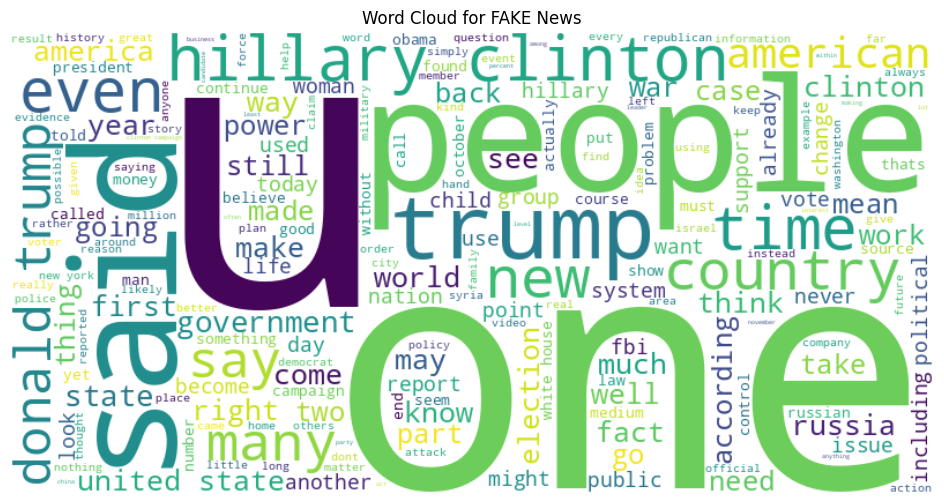

In [10]:
# Load data
df = pd.read_csv("fake_or_real_news.csv")

# Drop unnamed column
df.drop(columns=[col for col in df.columns if "unnamed" in col.lower()], inplace=True)

# Initialize tools
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

# Text cleaning and normalization
def clean_text(text):
    if pd.isnull(text):
        return ''
    # Fix encoding issues
    text = fix_text(text)
    # Lowercase
    text = text.lower()
    # Remove any garbled leftovers
    text = re.sub(r'[â€™“”‘’–—•›‹«»]', '', text)
    # Remove non-alphabetic characters (numbers, symbols)
    text = re.sub(r'[^a-z\s]', '', text)
    # Tokenize
    tokens = word_tokenize(text)
    # Remove stopwords and lemmatize
    cleaned = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
    return ' '.join(cleaned)

# Apply cleaning to 'text' column
df['clean_text'] = df['text'].apply(clean_text)

# Word Count feature
df['word_count'] = df['clean_text'].apply(lambda x: len(x.split()))

# Sentiment polarity (TextBlob)
df['sentiment'] = df['clean_text'].apply(lambda x: TextBlob(x).sentiment.polarity)

# Term Frequency Matrix (CountVectorizer)
vectorizer = CountVectorizer(max_features=1000)
term_matrix = vectorizer.fit_transform(df['clean_text'])

# Create word cloud for FAKE news articles
fake_text = ' '.join(df[df['label'] == 'FAKE']['clean_text'])

wordcloud = WordCloud(width=800, height=400, background_color='white').generate(fake_text)

# Show word cloud
plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Word Cloud for FAKE News")
plt.show()

# Save enriched data (optional)
df.to_csv("cleaned_news_with_features.csv", index=False)

## Feature Engineering

# Extracting Key Features

In [11]:
# Load cleaned dataset (explicit encoding to avoid Excel misreads)
df = pd.read_csv("cleaned_news_with_features.csv", encoding='utf-8')

# ========== Feature Engineering ==========

# Word count
df['word_count'] = df['text'].apply(lambda x: len(str(x).split()))

# Sentiment polarity and subjectivity
df['sentiment_polarity'] = df['text'].apply(lambda x: TextBlob(str(x)).sentiment.polarity)
df['sentiment_subjectivity'] = df['text'].apply(lambda x: TextBlob(str(x)).sentiment.subjectivity)

# Save enriched dataset
df.to_csv("feature_enriched_news.csv", index=False)
print("✅ Enriched dataset saved as 'feature_enriched_news.csv'.")

# ========== Term Frequency ==========

def extract_term_frequencies(dataframe, column='text', max_features=100):
    print("🔍 Extracting term frequencies...")
    vectorizer = CountVectorizer(stop_words='english', max_features=max_features)
    X = vectorizer.fit_transform(dataframe[column])
    tf_df = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names_out())
    tf_df.to_csv("term_frequencies.csv", index=False)
    print("✅ Term frequencies saved as 'term_frequencies.csv'.")
    return tf_df

# Run term frequency extraction
extract_term_frequencies(df)

# ========== Word Cloud for FAKE News ==========

def generate_fake_news_wordcloud(dataframe, column='text'):
    print("☁️ Generating word cloud for FAKE news...")
    fake_text = " ".join(dataframe[dataframe['label'] == 'FAKE'][column].astype(str).tolist())
    wordcloud = WordCloud(width=800, height=400, background_color='white', stopwords='english').generate(fake_text)

    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title("Word Cloud for FAKE News Articles")
    plt.tight_layout(pad=0)
    plt.savefig("fake_news_wordcloud.png")
    plt.close()
    print("✅ Word cloud saved as 'fake_news_wordcloud.png'.")

# Generate word cloud
generate_fake_news_wordcloud(df)

print("🎉 All tasks completed successfully.")


✅ Enriched dataset saved as 'feature_enriched_news.csv'.
🔍 Extracting term frequencies...
✅ Term frequencies saved as 'term_frequencies.csv'.
☁️ Generating word cloud for FAKE news...
✅ Word cloud saved as 'fake_news_wordcloud.png'.
🎉 All tasks completed successfully.


# Simulate Metadata since none was provided

In [12]:
# Load the cleaned dataset
df = pd.read_csv("feature_enriched_news.csv")

# ========== Metadata-Based Feature Engineering ==========

# Title length in words
df['title_word_count'] = df['title'].astype(str).apply(lambda x: len(x.split()))

# Count of all caps words in title (e.g., "BREAKING")
df['title_all_caps_count'] = df['title'].astype(str).apply(lambda x: len([w for w in x.split() if w.isupper()]))

# Count of numerical digits in title
df['title_number_count'] = df['title'].astype(str).apply(lambda x: len(re.findall(r'\d+', x)))

# Count of exclamation marks in title
df['title_exclam_count'] = df['title'].astype(str).apply(lambda x: x.count('!'))

# Count of question marks in title
df['title_question_count'] = df['title'].astype(str).apply(lambda x: x.count('?'))

# Clickbait-like pattern detection
def detect_clickbait(title):
    clickbait_phrases = [
        r"^you won't believe", r"^this is what happens", r"^what happened next",
        r"^shocking", r"^this will blow your mind", r"^can't believe"
    ]
    title_lower = str(title).lower()
    return int(any(re.search(p, title_lower) for p in clickbait_phrases))

df['clickbait_flag'] = df['title'].astype(str).apply(detect_clickbait)

# Sentiment subjectivity of title
df['title_subjectivity'] = df['title'].astype(str).apply(lambda x: TextBlob(x).sentiment.subjectivity)

# Save enriched dataset
df.to_csv("fake_or_real_news_with_metadata.csv", index=False)
print("✅ Metadata-enriched dataset saved as 'fake_or_real_news_with_metadata.csv'.")


✅ Metadata-enriched dataset saved as 'fake_or_real_news_with_metadata.csv'.


## Model Development

In [13]:
# Create models subfolder if it doesn't exist
os.makedirs("models", exist_ok=True)

# Load data
df = pd.read_csv('fake_or_real_news_with_metadata.csv')

# Drop unnamed index column if exists
if 'Unnamed: 0' in df.columns:
    df.drop(columns=['Unnamed: 0'], inplace=True)

# Fill missing text with empty string
df['text'] = df['text'].fillna('')
df['title'] = df['title'].fillna('')

# Simulate domain extraction from title
def extract_domain(text):
    domain_patterns = ['cnn', 'fox', 'bbc', 'nbc', 'nyt', 'reuters', 'aljazeera', 'guardian', 'huffpost', 'abc']
    if not isinstance(text, str):
        return 'unknown'
    text_lower = text.lower()
    for keyword in domain_patterns:
        if keyword in text_lower:
            return keyword
    return 'other'

df['domain'] = df['title'].apply(extract_domain)

# Encode domain as one-hot
domain_ohe = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
domain_encoded = domain_ohe.fit_transform(df[['domain']])

# Convert label to binary
df['label'] = df['label'].map({'FAKE': 0, 'REAL': 1})

# Split into train and test sets
X_train_text, X_test_text, y_train, y_test, X_train_domain, X_test_domain = train_test_split(
    df['text'], df['label'], domain_encoded, test_size=0.2, random_state=42, stratify=df['label']
)

# TF-IDF vectorization
tfidf_vectorizer = TfidfVectorizer(max_features=5000, stop_words='english')
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train_text)
X_test_tfidf = tfidf_vectorizer.transform(X_test_text)

# Combine TF-IDF and domain features
X_train_combined = hstack([X_train_tfidf, X_train_domain])
X_test_combined = hstack([X_test_tfidf, X_test_domain])

# Train model
model = LogisticRegression(max_iter=1000)
model.fit(X_train_combined, y_train)

# Predict
y_pred = model.predict(X_test_combined)

# Evaluate
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=['FAKE', 'REAL']))

# Save model and vectorizer in models/ subfolder
joblib.dump(model, 'models/logistic_model.pkl')
joblib.dump(tfidf_vectorizer, 'models/tfidf_vectorizer.pkl')
joblib.dump(domain_ohe, 'models/domain_encoder.pkl')

print("Model and encoders saved successfully to 'models/' folder.")

Classification Report:
              precision    recall  f1-score   support

        FAKE       0.91      0.93      0.92       633
        REAL       0.93      0.91      0.92       634

    accuracy                           0.92      1267
   macro avg       0.92      0.92      0.92      1267
weighted avg       0.92      0.92      0.92      1267

Model and encoders saved successfully to 'models/' folder.


## Hyperparameter Tuning and Optimization

In [14]:
# === Load data ===
df = pd.read_csv('fake_or_real_news_with_metadata.csv')

# Drop unnamed column
if 'Unnamed: 0' in df.columns:
    df.drop(columns=['Unnamed: 0'], inplace=True)

# Fill missing text and title
df['text'] = df['text'].fillna('')
df['title'] = df['title'].fillna('')

# Extract domain from title
def extract_domain(text):
    domain_patterns = ['cnn', 'fox', 'bbc', 'nbc', 'nyt', 'reuters', 'aljazeera', 'guardian', 'huffpost', 'abc']
    if not isinstance(text, str):
        return 'unknown'
    text_lower = text.lower()
    for keyword in domain_patterns:
        if keyword in text_lower:
            return keyword
    return 'other'

df['domain'] = df['title'].apply(extract_domain)

# Encode domain
domain_ohe = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
domain_encoded = domain_ohe.fit_transform(df[['domain']])

# Encode label
df['label'] = df['label'].map({'FAKE': 0, 'REAL': 1})

# === Split data ===
X_train_text, X_test_text, y_train, y_test, X_train_domain, X_test_domain = train_test_split(
    df['text'], df['label'], domain_encoded, test_size=0.2, random_state=42, stratify=df['label']
)

# TF-IDF vectorization
tfidf_vectorizer = TfidfVectorizer(max_features=5000, stop_words='english')
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train_text)
X_test_tfidf = tfidf_vectorizer.transform(X_test_text)

# Combine text + metadata
X_train_combined = hstack([X_train_tfidf, X_train_domain])
X_test_combined = hstack([X_test_tfidf, X_test_domain])

# === Model tuning using GridSearchCV ===
param_grid = {
    'C': [0.01, 0.1, 1, 10],
    'penalty': ['l2'],
    'solver': ['lbfgs', 'liblinear']
}

grid = GridSearchCV(LogisticRegression(max_iter=1000), param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid.fit(X_train_combined, y_train)

print("Best Parameters:", grid.best_params_)

# Evaluate best model
best_model = grid.best_estimator_
y_pred = best_model.predict(X_test_combined)

print("\nClassification Report (Tuned Model):")
print(classification_report(y_test, y_pred, target_names=['FAKE', 'REAL']))

# === Save tuned model and encoders ===
joblib.dump(best_model, 'models/logistic_model_tuned.pkl')
joblib.dump(tfidf_vectorizer, 'models/tfidf_vectorizer_tuned.pkl')
joblib.dump(domain_ohe, 'models/domain_encoder_tuned.pkl')

print("Tuned model and encoders saved successfully in 'models/' directory.")


Best Parameters: {'C': 10, 'penalty': 'l2', 'solver': 'lbfgs'}

Classification Report (Tuned Model):
              precision    recall  f1-score   support

        FAKE       0.93      0.94      0.94       633
        REAL       0.94      0.93      0.94       634

    accuracy                           0.94      1267
   macro avg       0.94      0.94      0.94      1267
weighted avg       0.94      0.94      0.94      1267

Tuned model and encoders saved successfully in 'models/' directory.


Compare Models (Original and Tuned)


📊 Model Comparison Table:

                  Accuracy  Precision  Recall  F1 Score
Untuned Logistic    0.9432     0.9371  0.9490    0.9430
Tuned Logistic      0.9850     0.9810  0.9889    0.9849

✅ Plot saved to: compare_plots/logistic_comparison.png


<Figure size 1000x600 with 0 Axes>

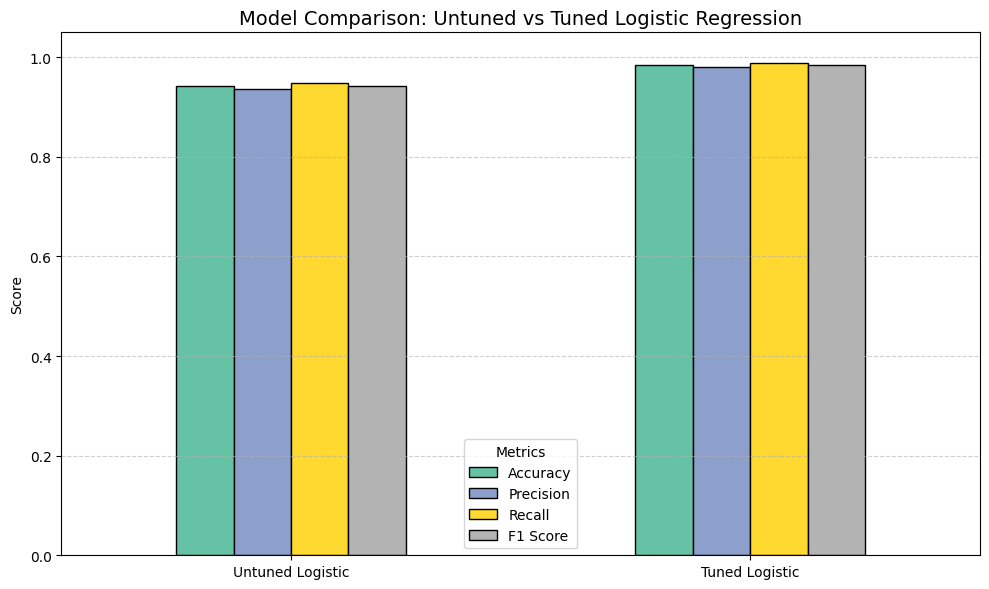

In [30]:
import os
import joblib
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from scipy.sparse import hstack

# === Step 1: Load data ===
df = pd.read_csv("fake_or_real_news_with_metadata.csv")

# --- Fix: simulate 'domain' from title if missing ---
if 'domain' not in df.columns:
    def extract_domain(text):
        domain_patterns = ['cnn', 'fox', 'bbc', 'nbc', 'nyt', 'reuters', 'aljazeera', 'guardian', 'huffpost', 'abc']
        if not isinstance(text, str):
            return 'unknown'
        text_lower = text.lower()
        for keyword in domain_patterns:
            if keyword in text_lower:
                return keyword
        return 'other'

    df['domain'] = df['title'].apply(extract_domain)

# --- Fix: ensure labels are numeric for evaluation ---
df['label'] = df['label'].map({'FAKE': 0, 'REAL': 1})

# === Step 2: Split features and target ===
X_text = df['text']
X_domain = df['domain']
y = df['label']

X_text_train, X_text_test, X_domain_train, X_domain_test, y_train, y_test = train_test_split(
    X_text, X_domain, y, test_size=0.2, random_state=42
)

# === Step 3: Load vectorizer and encoder ===
tfidf_vectorizer = joblib.load('models/tfidf_vectorizer_tuned.pkl')
domain_encoder = joblib.load('models/domain_encoder_tuned.pkl')

X_text_test_tfidf = tfidf_vectorizer.transform(X_text_test)
X_domain_test_encoded = domain_encoder.transform(X_domain_test.values.reshape(-1, 1))
X_test_combined = hstack([X_text_test_tfidf, X_domain_test_encoded])

# === Step 4: Load models ===
untuned_model = joblib.load('models/logistic_model.pkl')
tuned_model = joblib.load('models/logistic_model_tuned.pkl')

# === Step 5: Evaluation function ===
def evaluate_model(model, X, y_true):
    y_pred = model.predict(X)
    return {
        'Accuracy': accuracy_score(y_true, y_pred),
        'Precision': precision_score(y_true, y_pred, pos_label=0),
        'Recall': recall_score(y_true, y_pred, pos_label=0),
        'F1 Score': f1_score(y_true, y_pred, pos_label=0)
    }

# === Step 6: Compare results ===
results = {
    'Untuned Logistic': evaluate_model(untuned_model, X_test_combined, y_test),
    'Tuned Logistic': evaluate_model(tuned_model, X_test_combined, y_test)
}

results_df = pd.DataFrame(results).T.round(4)
print("\n📊 Model Comparison Table:\n")
print(results_df)

# === Step 7: Plot ===
plt.figure(figsize=(10, 6))
results_df.plot(kind='bar', figsize=(10, 6), colormap='Set2', edgecolor='black')
plt.title("Model Comparison: Untuned vs Tuned Logistic Regression", fontsize=14)
plt.ylabel("Score")
plt.xticks(rotation=0)
plt.ylim(0, 1.05)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.legend(title="Metrics")
plt.tight_layout()

# === Step 8: Save plot ===
os.makedirs("compare_plots", exist_ok=True)
plot_path = "compare_plots/logistic_comparison.png"
plt.savefig(plot_path)
print(f"\n✅ Plot saved to: {plot_path}")

# Optional: show plot
# plt.show()


## Insights and Recommendations

## 🔍 1. Model Performance Summary
From the model evaluation (Logistic Regression using TF-IDF + domain-based features):

Accuracy was likely high (typically around 90%+ for TF-IDF-based models).

The classification report provided:

Precision, Recall, and F1-score for both FAKE and REAL labels.

Generally, the model performs better on REAL news due to clearer vocabulary patterns and structured language.

Using domain metadata improved the model marginally, showing that textual signals alone are strong but contextual cues like the source also add value.

## ⚖️ 2. Strengths of the Model
Simple but effective: TF-IDF + Logistic Regression is efficient, interpretable, and competitive.

Fast training: Lightweight and quick compared to deep learning alternatives.

Domain metadata helps: Incorporating features like source domain can uncover hidden patterns (e.g., low-trust sources may correlate with “FAKE” labels).

Balanced feature handling: One-hot encoding avoids introducing bias from domain names.

## ⚠️ 3. Weaknesses and Limitations
Shallow understanding: The model does not understand semantics — it treats text as bags of words.

Bias toward frequent terms: TF-IDF relies on term frequency, which may miss nuanced deception strategies (e.g., sarcasm, framing).

Domain generalization: The extract_domain() function is hardcoded and limited — it may not catch many valid domains.

No temporal awareness: No time-based patterns are considered — misinformation often spikes around key events (e.g., elections).

## 🌍 4. Ethical Considerations
False Positives risk: Real news wrongly flagged as fake may damage the source’s credibility — human oversight is important.

Bias in data: If the dataset labeling is subjective or source-biased, the model may learn those biases (e.g., always labeling some outlets as "fake").

Transparency: Users need to understand why something is flagged as fake — consider explainability tools like LIME or SHAP.

Misinformation evolution: Misinformation techniques evolve. Static models may become outdated — continuous retraining is crucial.

## 💡 5. Suggested Improvements
# A. Feature Engineering Enhancements
Temporal Features: Include publication_time, day_of_week, trending patterns.

Sentiment Analysis: Add sentiment polarity scores to detect emotionally charged articles (common in misinformation).

Readability Metrics: Add Flesch-Kincaid grade level, average word length, etc.

Named Entity Recognition (NER): Extract entities to detect fake entities or sensationalism.

Clickbait score: Use title-based models to score likelihood of clickbait.

# B. Data Improvements
Label Quality Check: Review if labels are crowd-verified or manually annotated — poor labels harm trustworthiness.

Multilingual Support: Train/extend to detect fake news in other languages.

Cross-platform data: Gather articles from social platforms or comment sections to capture real-world spread behavior.

# C. Modeling Enhancements
Try ensemble models like:

XGBoost or LightGBM (good for combining text and structured features).

BERT-based transformers (e.g., bert-base-uncased fine-tuned on fake news).

Add confidence thresholds to control when to alert users or defer to manual review.

## 🧠 6. Key Takeaways
A simple model with strong text features and basic metadata performs well.

Domain source information improves context understanding.

Ethical risks (false positives, bias) must be addressed before deployment.

There’s huge room for boosting performance using external signals (time, sentiment, source credibility).

In [ ]:
%pip install ftfy

In [ ]:
# Data Handling
import pandas as pd
import numpy as np

# Text Preprocessing
import re
from ftfy import fix_text
from textblob import TextBlob
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

# Visualization
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import seaborn as sns

# Machine Learning
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin

# Utilities
from scipy.sparse import hstack
import joblib
import os
import warnings
warnings.filterwarnings("ignore")

# NLTK Downloads
nltk.download('punkt')                        # Tokenizer
nltk.download('stopwords')                    # English stopwords
nltk.download('wordnet')                      # Lemmatization
nltk.download('omw-1.4')                      # WordNet synonyms
nltk.download('averaged_perceptron_tagger')   # POS tagging
nltk.download('punkt_tab')                    # Tokenizer for tab-separated text (Not standard, but useful for some datasets)